In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

embd = OpenAIEmbeddings()

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-06-23-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-06-23-adv-attack/llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(doc_list)

vectorstore = FAISS.from_documents(documents=doc_splits, embedding=embd)

retriever = vectorstore.as_retriever()



In [7]:
#Retriver Grader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

#Data Model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")
    
# llm with function calling
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

#prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. 
  If the document contains keywords related to the user question, grade it as relevant. 
  Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Question: {question}"),
        ("human", "Retrieved document: {document}"),
    ]
) 
#chain
retrival_gender = prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_text = docs[1].page_content  
print(retrival_gender.invoke({"question": question, "document": doc_text}))


C:\Users\bhatt\AppData\Roaming\Python\Python312\site-packages\langchain_openai\chat_models\base.py:1963: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


binary_score='yes'


In [8]:
#Generate
from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#chain
rag_chain = prompt | llm | StrOutputParser() 

#run
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

The agent memory in this context refers to the long-term memory module that records the agents' experiences in natural language. It includes observations and events provided by the agent, which can trigger new natural language statements. The memory is used to inform the agent's behavior, surface context, and guide future actions.


In [9]:
### query rewrite
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

#prompt
system = """
You are a question rewriter. 
You will be given a question and a context. 
You will rewrite the question to be more relevant to the context.
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial: \n\n {question} \n Formulate an improved question"),
    ]
)

question_rewrite = prompt | llm | StrOutputParser()
question_rewrite.invoke({"question": question})


'What strategies can be implemented to enhance memory retention in artificial intelligence agents?'

In [10]:
### Serach

from langchain_community.tools.tavily_search import TavilySearchResults

web_seatch_tool = TavilySearchResults(k=3)

C:\Users\bhatt\AppData\Local\Temp\ipykernel_16776\3445835948.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_seatch_tool = TavilySearchResults(k=3)


In [ ]:
### Creating state graph
from typing import TypedDict,List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question:question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [19]:
from langchain_core.documents import Document

def retrive(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to the state
    """
    print("---RETRIEVE---")
    question = state["question"]
    
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer to question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to the state
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    
    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If a document is not relevant, we will flag it.
    """
    print("---CHECK DOCUMENT RELEVANCE---")
    question = state["question"]
    documents = state["documents"]
    
    filtered_docs = []
    web_serch = "No"
    for d in documents:
        score = retrival_gender.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_serch = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_serch}    

def transform_query(state):
    """
    Transform the query to produce a better question to search on
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Run
    new_question = question_rewrite.invoke({"question": question})
    return {"documents": documents, "question": new_question}

def wen_search(state):
    """
    Search google  for relevant documents
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    docs = web_seatch_tool.invoke(question)
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}

## Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer or re-generate a question.
    """
    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]
    web_search = state["web_search"]

    if web_search == "Yes":
        # We have relevant results, so generate answer
        print("---DECISION: All the documents are not relevant to question, transform query---")
        return "transform_query"
    else:
        # We do not have relevant results, so generate a question
        print("---DECISION: GENERATE---")
        return "generate"


In [20]:
## Node and edges
from langgraph.graph import StateGraph, END, START

workflow = StateGraph(GraphState)

#Define the nodes
workflow.add_node("retrieve", retrive)  # retrieval
workflow.add_node("grade_documents", grade_documents)  # grading
workflow.add_node("generate", generate)  # generation
workflow.add_node("transform_query", transform_query)  # transform
workflow.add_node("web_search", wen_search)  # web search

#Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

#compile
app = workflow.compile()


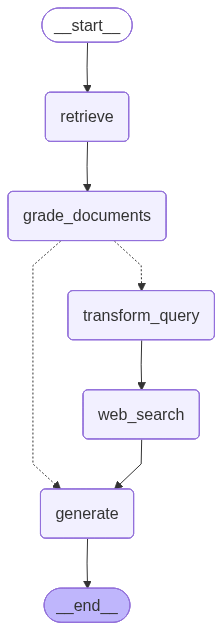

In [21]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
app.invoke({"question": "what are the types of agent memory?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: All the documents are not relevant to question, transform query---
---TRANSFORM QUERY---
---WEB SEARCH---
---GENERATE---


{'question': 'What are the different types of memory that an artificial intelligence agent can utilize in its decision-making processes?',
 'generation': 'An artificial intelligence agent can utilize short-term memory for in-context learning and long-term memory for retaining and recalling information over extended periods. Short-term memory is finite and restricted by the context window length of the model, while long-term memory can be accessed via fast retrieval from an external vector store. These memory types play a crucial role in enabling AI agents to process information, learn, and adapt in decision-making processes.',
 'web_search': 'Yes',
 'documents': [Document(id='28956674-8d53-4f57-8d92-70923f04c140', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as A